# 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#train_link = "https://bit.ly/38Lia2e"
#test_link = "https://bit.ly/3h5eqNL"
#train1 = pd.read_csv(train_link)
#test1 = pd.read_csv(test_link)

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train1 = pd.read_csv('data/train.csv')
test1 = pd.read_csv('data/test.csv')

In [4]:
train.shape

(1460, 81)

In [5]:
test.shape

(1459, 80)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
train['FullBath']

0       2
1       2
2       2
3       1
4       2
       ..
1455    2
1456    2
1457    2
1458    1
1459    1
Name: FullBath, Length: 1460, dtype: int64

In [8]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [9]:
np.corrcoef(train['SalePrice'], train['OverallQual'])

array([[1.       , 0.7909816],
       [0.7909816, 1.       ]])

# 전처리


## 전처리 시작

### 필요한 함수 정의

In [173]:
def null_count(dataset):
    '''
    해당 데이터셋에 결측치가 있는 feature와 개수 출력
    '''
    return dataset.isnull().sum()[dataset.isnull().sum()!=0]
    
def null_check(feature):
    '''
    해당 feature의 결측치가 각 데이터셋에 얼마나 있는지 확인.
    dataset도 input으로 받아야 할지 고민.
    '''
    print('--', feature, '--')
    print('train :', train[feature].isnull().sum())
    print('test :', test[feature].isnull().sum())

def val_list(dataset, feature):
    '''
    해당 dataset의 feature가 가진 value들 중복 없이 리스트로 출력
    '''
    return list(set(dataset[feature].values.tolist()))

#val_list = set(train['MSZoning'].values.tolist()) - 중복 없이 value종류 추출 
# 근데 이건 순서가 내 맘대로 안됨

def val_count(feature):
    '''
    train, test 데이터의 value_count를 같이 출력
    input에 데이터셋도 받는게 좋을지..?
    '''
    print('-----', feature, '-----')
    print('---- train ----')
    print(train[feature].value_counts())
    print('---- test ----')
    print(test[feature].value_counts(),'\n')

def map_order(dataset, feature, val_list):
    '''
    Value들을 0부터 순서대로 매핑
    데이터셋(train/test), feature명, 원하는 순서대로 value_list 입력
    '''
    mapping = dict(zip(val_list, range(len(val_list))))
    return dataset[feature].map(mapping) #원하는 순서대로 0부터 매핑된 컬럼 출력


def val_cat(dataset, feature):
    '''
    dataset, feature를 입력받아서 해당 feature에 대해 categorize
    '''
    val_list = set(dataset[feature].values.tolist())
    for feat in val_list:
        dataset[feat] = (dataset[feature]==feat).astype(int)
    dataset = dataset.drop(feature, axis = 1)
    
def avg_price(feature):
    '''
    train set 내의 해당 feature의 value들에 따른 가격의 평균
    '''
    for feat in set(train[feature].values.tolist()):
        mean_price = train['SalePrice'][train[feature] == feat].mean()
        print(feat, ':', mean_price)
        
def price_plot(feature):
    '''
    train set 내의 해당 feature의 value에 따른 가격의 평균 plot 그래프로 출력
    '''
    train.groupby(feature).mean()['SalePrice'].plot()
    
def brief():
    '''
    feature의 분류를 브리핑
    '''
    print('그대로 넣을 거 {}개: \n'.format(len(feature_raw)),feature_raw,'\n')
    print('모아놓고 그대로 넣을지? one-hot을 할지 등 {}개: \n'.format(len(feature_dis)),feature_dis,'\n')
    print('매핑 할 데이터 {}개: \n'.format(len(feature_map)),feature_map,'\n')
    print('one-hot encoding 시킬 것 {}개: \n'.format(len(feature_onehot)),feature_onehot,'\n')
    print('따로 봐야 할 것 {}개: \n'.format(len(feature_extra)),feature_extra,'\n')
    print('삭제할 것 {}개: \n'.format(len(feature_del)),feature_del,'\n')

### feature 분류

- feature들을 하나씩 보면서 5가지 분류로 나눌 계획.  
- 각 분류별로 리스트에 feature이름 저장.  
  
  
- <span class="mark">feature_raw</span> : 그대로 넣을거   
     - 넓이, 길이 등 연속적인 숫자 데이터
- <span class="mark">feature_dis</span> : 모아놓고 그대로 넣을지? one-hot을 할지 등
     - 개수, 유무(0/1) 등 discrete 한 숫자 데이터
- <span class="mark">feature_map</span> : 매핑 할 데이터   
    - 경사도고 낮음 -> 높음 처럼 문자이지만 순서가 있어보이는 경우 숫자로 매핑
- <span class="mark">feature_onehot</span> : one-hot encoding 시킬 것
    - 각각의 특성이 독립?이라서 컬럼을 새로 만들어 주는게 좋아 보이는 경우
- <span class="mark">feature_extra</span> : 따로 봐야 할 것  
    - 그래프를 그려본다거나, 가격과의 관계를 직접 보고 판단
- <span class="mark">feature_del</span> : 삭제
    - 필요 없다고 판단되어 삭제 할 데이터
    

In [11]:
feature_raw = []
feature_dis = []
feature_map = []
feature_onehot = []
feature_extra = []
feature_del = []

In [174]:
brief()

그대로 넣을 거 15개: 
 ['LotFrontage', 'LotArea', 'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'] 

모아놓고 그대로 넣을지? one-hot을 할지 등 17개: 
 ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold'] 

매핑 할 데이터 17개: 
 ['MSZoning', 'LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'] 

one-hot encoding 시킬 것 16개: 
 ['Street', 'Alley', 'LotConfig', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'BsmtExposure', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition'] 

따로 봐야 할 것 12개: 
 

In [13]:
null_count(train)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [14]:
val_list(train, 'Street')

['Grvl', 'Pave']

In [15]:
val_count('Street')

----- Street -----
---- train ----
Pave    1454
Grvl       6
Name: Street, dtype: int64
---- test ----
Pave    1453
Grvl       6
Name: Street, dtype: int64 



In [16]:
feature_onehot

[]

## Feature들 살펴보기

----------------------------------
### ID

#### 의견

그냥 아이디임.
삭제해도 될 듯.

#### 데이터 확인

In [17]:
train['Id'].head()

0    1
1    2
2    3
3    4
4    5
Name: Id, dtype: int64

#### 분류

In [18]:
feature_del.append('Id')

----------------------------------
### MSSubClass

- The building class  
- 빌딩의 클래스?  

#### 의견
- discrete한 값임
- 숫자가 크다고 좋은게 아니라서. 다른 방법이 필요함.

#### 데이터 확인
- 숫자가 크다고 무조건 좋지 않음 (ex 180)
- 그래프 그려볼것

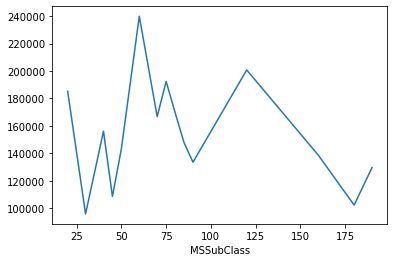

In [19]:
price_plot('MSSubClass')

#### 결측치 확인
- 결측치 없음

#### 분류
- discrete한 값이니까 feature_dis 리스트에 추가

In [20]:
feature_dis.append('MSSubClass')

----------------------------------
### MSZoning

- The general zoning classification  
- 주거구역 / 상업구역 등 집이 위치한 구역?을 나타냄.

#### 의견

- C, FV 생각하면 one-hot encoding 하고 싶음.
- 근데 RL, RM, RH간에는 순서?가 있어 보여서..  
- 일단 매핑 해보자 1~5

#### 데이터 확인
- RL -> RM -> RH 순으로 인구 밀집도가 높음.(얘네가 데이터의 대부분임)  
- 나머지 FV(물에 떠있는 집;;), C(상업지구)는 어떻게 처리할지..  

In [21]:
val_count('MSZoning')

----- MSZoning -----
---- train ----
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
---- test ----
RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64 



#### 결측치 확인
- test셋에 결측치 4개.
- 데이터를 보면 RL이 압도적으로 많으니까.. RL로 결측 채워보자

In [22]:
null_check('MSZoning')

-- MSZoning --
train : 0
test : 4


In [23]:
test['MSZoning'].fillna('RL', inplace=True)
null_check('MSZoning')

-- MSZoning --
train : 0
test : 0


#### 매핑
- C, FV 생각하면 <span class="mark">카테고라이즈</span> 하고 싶은데 근데 RL, RM, RH간에는 순서?가 있어 보여서..  
->일단 RL -> RM -> RH -> C -> FV 순으로 숫자로 매핑해보기로(0~4)

In [24]:
# RL -> RM -> RH -> C -> FV 
map_MSZoning = {'RL':1, 'RM':2, 'RH':3, 'C (all)':4, 'FV':5}
train['MSZoning'] = train['MSZoning'].map(map_MSZoning)
test['MSZoning'] = test['MSZoning'].map(map_MSZoning)

In [25]:
val_count('MSZoning')

----- MSZoning -----
---- train ----
1    1151
2     218
5      65
3      16
4      10
Name: MSZoning, dtype: int64
---- test ----
1    1118
2     242
5      74
4      15
3      10
Name: MSZoning, dtype: int64 



#### 분류
- 일단 순서를 줘서 매핑을 했으니까 feature_order 리스트에 'MSZoning' 넣기

In [26]:
feature_map.append('MSZoning')

----------------------------------
### LotFrontage / LotArea

- LotFrontage : Linear feet of street connected to property
- LotArea : Lot size in square feet

#### 의견

- 둘 다 길이, 넓이로 숫자 데이터라서 그냥 넣을 것.
- <span class="mark">값이 큰데 어떻게 normalize할지?</span>
- <span class="mark">길이가 길면, 면적도 넓어질텐데 둘을 하나로 합칠 수 있나?</span>

#### 데이터 확인

In [27]:
val_count('LotFrontage')

----- LotFrontage -----
---- train ----
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
112.0      1
138.0      1
149.0      1
38.0       1
111.0      1
Name: LotFrontage, Length: 110, dtype: int64
---- test ----
60.0     133
80.0      68
70.0      63
50.0      60
75.0      52
        ... 
149.0      1
117.0      1
121.0      1
101.0      1
22.0       1
Name: LotFrontage, Length: 115, dtype: int64 



In [28]:
val_count('LotArea')

----- LotArea -----
---- train ----
7200     25
9600     24
6000     17
8400     14
9000     14
         ..
13031     1
10991     1
8944      1
6897      1
8190      1
Name: LotArea, Length: 1073, dtype: int64
---- test ----
9600     20
7200     18
6000     17
9000     15
7500     12
         ..
10990     1
8088      1
13041     1
6900      1
12285     1
Name: LotArea, Length: 1106, dtype: int64 



#### 결측치 확인
- LotFrontage에 결측치가 꽤 많음
- 넓이에 따라서 (넓으면 길이도 길게) 넣어주면 좋을거같음

In [29]:
null_check('LotFrontage'), null_check('LotArea')

-- LotFrontage --
train : 259
test : 227
-- LotArea --
train : 0
test : 0


(None, None)

- 길이 / 넓이 의 비율을 평균내서, 이 비율을 넓이에 곱해줘서 결측치를 채워줄거임.
- 다행히도 넓이는 결측이 없어서 ㅎㅎ (다행히?다행이?)

In [30]:
#Lot_ratio : train/test 데이터의 비율을 다 구해서 평균
Lot_ratio = ((train['LotFrontage']/train['LotArea']).mean() + (test['LotFrontage']/test['LotArea']).mean())/2
train['LotFrontage'].fillna(train['LotArea']*Lot_ratio, inplace=True)
test['LotFrontage'].fillna(test['LotArea']*Lot_ratio, inplace=True) 

In [31]:
null_check('LotFrontage')

-- LotFrontage --
train : 0
test : 0


#### 분류
- 숫자(길이, 넓이) 데이터니까 일단 그냥 넣기
- Normalize에 대한 고민.

In [32]:
feature_raw.append('LotFrontage')
feature_raw.append('LotArea')

----------------------------------
### Street / Alley

- 거리, 골목의 유형?

#### 의견

- Street는 Gravl, Pave를 categorize
- Alley는 NA 까지 3개로 categorize?
- <span class="mark">그냥 0/1/2를 쓰면 안되는지?</span>

#### 데이터 확인
- Gravel / Pave / NA(골목이 없음)

In [33]:
val_count('Street'), val_count('Alley')

----- Street -----
---- train ----
Pave    1454
Grvl       6
Name: Street, dtype: int64
---- test ----
Pave    1453
Grvl       6
Name: Street, dtype: int64 

----- Alley -----
---- train ----
Grvl    50
Pave    41
Name: Alley, dtype: int64
---- test ----
Grvl    70
Pave    37
Name: Alley, dtype: int64 



(None, None)

#### 결측치 확인

- Alley에 골목이 없는 경우 null 값이 들어가 있는데, 'NA'로 채워주기

In [34]:
null_check('Street'), null_check('Alley')

-- Street --
train : 0
test : 0
-- Alley --
train : 1369
test : 1352


(None, None)

In [35]:
train['Alley'].fillna('NA', inplace=True)
test['Alley'].fillna('NA', inplace=True)

In [36]:
null_check('Alley')

-- Alley --
train : 0
test : 0


#### 분류
- feature_onehot에 추가, 한꺼번에 one-hot encoding

In [37]:
feature_onehot.append('Street')
feature_onehot.append('Alley')

----------------------------------
### LotShape

- General shape of property

#### 의견

- Reg -> IR3 순으로 1,2,3,4 으로 매핑

#### 데이터 확인

- Regular부터, IR의 숫자가 커질수록 안좋은거.

In [38]:
val_count('LotShape')

----- LotShape -----
---- train ----
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
---- test ----
Reg    934
IR1    484
IR2     35
IR3      6
Name: LotShape, dtype: int64 



#### 결측치 확인
- 없음

#### 매핑
- Reg -> IR3 을 1->4 순으로 매핑

In [39]:
map_LotShape = {'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}
train['LotShape'] = train['LotShape'].map(map_LotShape)
test['LotShape'] = test['LotShape'].map(map_LotShape)

In [40]:
val_count('LotShape')

----- LotShape -----
---- train ----
1    925
2    484
3     41
4     10
Name: LotShape, dtype: int64
---- test ----
1    934
2    484
3     35
4      6
Name: LotShape, dtype: int64 



#### 분류
- 순서대로 매핑해줬고, feature_map에 추가

In [41]:
feature_map.append('LotShape')

----------------------------------
### LandContour

- Flatness of the property
- 경사도 : 얼마나 평평한지?

#### 의견

- 경사가 낮음 -> 높음 순으로 매핑
- Lv1 -> Low -> HLS -> Bnk 순으로 매핑
- <span class="mark">여기도 0이 너무 많은데..</span>

#### 데이터 확인
- Lvl : 거의 평지 / Near Flat/Level 
- Bnk : 경사가 가장 심하다고 봐야하나? / Bank - Quick and Significant rise
- HLS : 경사가 꽤 있음 / Hillside - Significant slope
- Low : 경사가 낮음 / Depression

In [42]:
val_count('LandContour')

----- LandContour -----
---- train ----
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
---- test ----
Lvl    1311
HLS      70
Bnk      54
Low      24
Name: LandContour, dtype: int64 



#### 결측치 확인
- 없음

#### 매핑

In [43]:
map_LandContour = {'Lvl':1, 'Low':2, 'HLS':3, 'Bnk':4}
train['LandContour'] = train['LandContour'].map(map_LandContour)
test['LandContour'] = test['LandContour'].map(map_LandContour)

In [44]:
val_count('LandContour')

----- LandContour -----
---- train ----
1    1311
4      63
3      50
2      36
Name: LandContour, dtype: int64
---- test ----
1    1311
3      70
4      54
2      24
Name: LandContour, dtype: int64 



#### 분류
- 매핑했으므로 feature_map에 추가

In [45]:
feature_map.append('LandContour')

----------------------------------
### Utilities

#### 의견

train set에서 1개 빼고 모두 AllPub이고  
test set에도 결측 2개 제외하고는 모두 AllPub.  
-> 제거해도 될지도?

#### 데이터 확인 / 결측치 확인

- AllPub : 다 있음
- NoSewr : 전기, 가스, 물
- NoSeWa : 전기, 가스
- ELO : 전기만 있음

In [46]:
val_count('Utilities')

----- Utilities -----
---- train ----
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
---- test ----
AllPub    1457
Name: Utilities, dtype: int64 



#### 분류
- 컬럼을 지워버릴거니까 feature_del에 추가.

In [47]:
feature_del.append('Utilities')

----------------------------------
### !!! LotConfig

- Lot Configuration
- Lot(마당/마당+집?)의 구성

#### 의견

- 일단 one-hot encoding
- 그래프 그려보기?

#### 데이터 확인
- 대부분 inside

In [48]:
val_count('LotConfig')

----- LotConfig -----
---- train ----
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
---- test ----
Inside     1081
Corner      248
CulDSac      82
FR2          38
FR3          10
Name: LotConfig, dtype: int64 



- 그래프 그려보기

In [49]:
avg_price('LotConfig')

Inside : 176938.0475285171
CulDSac : 223854.6170212766
FR3 : 208475.0
FR2 : 177934.5744680851
Corner : 181623.4258555133


#### 결측치 확인
- 없음

#### 분류

- 추가적으로 고민해보는걸루

In [50]:
feature_onehot.append('LotConfig')

----------------------------------
### LandSlope

- 경사도
- Gentle -> Moderate -> Severe

#### 의견

- 위에 LandContour랑 차이가 뭔지? / 합치거나 할 수 있을지?
- 일단 경사도 순으로 매핑

#### 데이터 확인

- 대부분 다 젠틀하다고 나옴.

In [51]:
val_count('LandSlope')

----- LandSlope -----
---- train ----
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
---- test ----
Gtl    1396
Mod      60
Sev       3
Name: LandSlope, dtype: int64 



#### 결측치 확인
- 없음

In [52]:
null_check('LandSlope')

-- LandSlope --
train : 0
test : 0


#### 매핑
- Gtl -> Mod -> Sev 순으로

In [53]:
map_LandSlope = {'Gtl':1, 'Mod':2, 'Sev':3}
train['LandSlope'] = train['LandSlope'].map(map_LandSlope)
test['LandSlope'] = test['LandSlope'].map(map_LandSlope)

In [54]:
val_count('LandSlope')

----- LandSlope -----
---- train ----
1    1382
2      65
3      13
Name: LandSlope, dtype: int64
---- test ----
1    1396
2      60
3       3
Name: LandSlope, dtype: int64 



#### 분류

In [55]:
feature_map.append('LandSlope')

----------------------------------
### !!! Neighborhood

- 도시 경계? 어디랑 인접해있는지?

#### 의견

- 모르겠다 근데 one-hot을 하기에도 종류가 너무 많은거 아닌가?

#### 데이터 확인

그래프 그려보기

In [56]:
val_count('Neighborhood')

----- Neighborhood -----
---- train ----
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64
---- test ----
NAmes      218
OldTown    126
CollgCr    117
Somerst     96
Edwards     94
NridgHt     89
Gilbert     86
Sawyer      77
SawyerW     66
Mitchel     65
NWAmes      58
IDOTRR      56
Crawfor     52
BrkSide     50
Timber      34
NoRidge     30
StoneBr     26
SWISU       23
MeadowV     20
ClearCr     16
BrDale      14
NPkVill     14
Veenker     13
Blmngtn     11
Blueste      8
Name: Neighborhood, dtype: int64 



In [57]:
avg_price('Neighborhood')

CollgCr : 197965.77333333335
OldTown : 128225.30088495575
SWISU : 142591.36
Sawyer : 136793.13513513515
NWAmes : 189050.0684931507
Blueste : 137500.0
Edwards : 128219.7
BrDale : 104493.75
Somerst : 225379.83720930232
NridgHt : 316270.6233766234
SawyerW : 186555.7966101695
IDOTRR : 100123.78378378379
StoneBr : 310499.0
Timber : 242247.44736842104
Crawfor : 210624.72549019608
Blmngtn : 194870.88235294117
NoRidge : 335295.31707317074
BrkSide : 124834.05172413793
Gilbert : 192854.50632911394
NAmes : 145847.08
Veenker : 238772.72727272726
MeadowV : 98576.4705882353
Mitchel : 156270.1224489796
NPkVill : 142694.44444444444
ClearCr : 212565.42857142858


#### 결측치 확인
- 없음

#### 분류
- 그냥 one-hot을 해버리기에 값들이 너무 다양한데, 고민해보기

In [58]:
feature_extra.append('Neighborhood')

----------------------------------
### !!! Condition1/2

- Condition
- 그린벨트여부, 주변에 철도 여부 등등

#### 의견

- 1과 2를 합치는건 좋아 보이는데.
- 근데 단순 컨디션 갯수로 판단하는게 괜찮을까?
- one-hot을 해도 적합할까?

#### 데이터 확인

- 대부분 노말임.

In [59]:
val_count('Condition1')

----- Condition1 -----
---- train ----
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64
---- test ----
Norm      1251
Feedr       83
Artery      44
RRAn        24
PosN        20
RRAe        17
PosA        12
RRNe         4
RRNn         4
Name: Condition1, dtype: int64 



- norm보다 싼거도 있네  
- 옵션이 있다고 무조건 좋은게 아닌가봄..  
- 그러면 컨디션 개수로 묶는건 진짜 아닌거같은뎅..

In [60]:
avg_price('Condition2')

Artery : 106500.0
PosA : 325000.0
Feedr : 121166.66666666667
RRAn : 136905.0
PosN : 284875.0
Norm : 181169.40553633217
RRAe : 190000.0
RRNn : 96750.0


In [61]:
# 컨디션 2가 Norm이 아닌데, 컨디션 1이 Norm인 경우는 없음.
train['Condition1'][train['Condition2']!='Norm']

9       Artery
29       Feedr
63        RRAn
88       Feedr
184       RRAn
523       PosN
531       RRNn
548      Feedr
583     Artery
589       RRAn
825       PosN
974       RRAn
1003     Feedr
1186    Artery
1230     Feedr
Name: Condition1, dtype: object

#### 결측치 확인
- 없음~

#### 분류

In [62]:
feature_extra.append('Condition1')
feature_extra.append('Condition2')

----------------------------------
### BldgType

- 주거 형태 
- 1Fam : 독채
- 2FmCon : 독채에 두 가구 거주
- Duplx : Duplex(이중?)
- TwnhsE : Townhouse End unit
- Twnhs(I) : Townhouse Inside unit
    - 설명 문서엔 TwnhsI 였는데 실제 값은 Twnhs 가 들어가있음

#### 의견

- 2fmCon < Duplex <= Twnhs <<<< TwnhsE <= 1Fam
- 근데 순서가 약간 애매함. 생각했던거랑 실제 가격이랑
- 애매하니까 one-hot 가자

#### 데이터 확인

In [63]:
val_count('BldgType')

----- BldgType -----
---- train ----
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64
---- test ----
1Fam      1205
TwnhsE     113
Duplex      57
Twnhs       53
2fmCon      31
Name: BldgType, dtype: int64 



#### 결측치 확인
- 없다!

#### 분류

In [64]:
feature_onehot.append('BldgType')

----------------------------------
### HouseStyle

- 주거 스타일

#### 의견

- one-hot 하자

#### 데이터 확인

In [65]:
val_count('HouseStyle')

----- HouseStyle -----
---- train ----
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64
---- test ----
1Story    745
2Story    427
1.5Fin    160
SLvl       63
SFoyer     46
2.5Unf     13
1.5Unf      5
Name: HouseStyle, dtype: int64 



In [66]:
avg_price('HouseStyle')

2.5Unf : 157354.54545454544
1.5Fin : 143116.74025974027
2Story : 210051.76404494382
SLvl : 166703.38461538462
1Story : 175985.4779614325
SFoyer : 135074.48648648648
1.5Unf : 110150.0
2.5Fin : 220000.0


#### 결측치 확인
- 없음!

#### 분류

In [67]:
feature_onehot.append('HouseStyle')

----------------------------------
### OverallQual / OverallCond

- 전체적인 퀄리티, 컨디션을 평가한 지표

#### 의견

- 그냥 숫자라서 그대로 넣으면 될 듯하긴 함
- 상관계수가 엄청 높음.

#### 데이터 확인

In [68]:
val_count('OverallQual'), val_count('OverallCond')

----- OverallQual -----
---- train ----
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64
---- test ----
5     428
6     357
7     281
8     174
4     110
9      64
3      20
10     13
2      10
1       2
Name: OverallQual, dtype: int64 

----- OverallCond -----
---- train ----
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64
---- test ----
5    824
6    279
7    185
8     72
4     44
3     25
9     19
1      6
2      5
Name: OverallCond, dtype: int64 



(None, None)

In [69]:
np.corrcoef(train['OverallQual'], train['SalePrice'])

array([[1.       , 0.7909816],
       [0.7909816, 1.       ]])

#### 결측치 확인
- 없음!

#### 분류
- discrete한 값이니까

In [70]:
feature_dis.append('OverallQual')
feature_dis.append('OverallCond')

----------------------------------
### YearBuilt / YearRemodAdd

- 지어진 년도 / 리모델링한 년도

#### 의견

- 같은 년도에 공사를 했어도, 새 건물이 리모델링한 건물보다 좋겠지?
- 일단 각각 넣고 두 feature를 합칠 방법이 있을지?
- normalize : 1872를 빼주자

#### 데이터 확인

In [71]:
# 가장 오래전에 지어진 건물의 년도 출력
min(val_list(train, 'YearBuilt')[0], val_list(test, 'YearBuilt')[0])

1872

#### 결측치 확인
- 없음!

#### Normalize

- 가장 오래된 년도인 1872년 빼주자

In [72]:
train['YearBuilt'] -= 1872
test['YearBuilt'] -= 1872
train['YearRemodAdd'] -= 1872
test['YearRemodAdd'] -= 1872

In [73]:
train['YearBuilt'].head()

0    131
1    104
2    129
3     43
4    128
Name: YearBuilt, dtype: int64

#### 분류
- discrete

In [74]:
feature_dis.append('YearBuilt')
feature_dis.append('YearRemodAdd')

----------------------------------
### RoofStyle / RoofMatl

- 지붕 스타일, 재질

#### 의견

- one-hot.
- 근데 특정 값만 엄청 많은데 one-hot을 하면 0에 가까운 열들이 생기는 문제?
- 그래프 그려보기ㅣ

#### 데이터 확인

거의 다 Gable / CompShg 임.

In [75]:
val_count('RoofStyle'), val_count('RoofMatl')

----- RoofStyle -----
---- train ----
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64
---- test ----
Gable      1169
Hip         265
Gambrel      11
Flat          7
Mansard       4
Shed          3
Name: RoofStyle, dtype: int64 

----- RoofMatl -----
---- train ----
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Roll          1
ClyTile       1
Membran       1
Name: RoofMatl, dtype: int64
---- test ----
CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: RoofMatl, dtype: int64 



(None, None)

#### 결측치 확인
- 없음!

#### 분류

In [76]:
feature_onehot.append('RoofStyle')
feature_onehot.append('RoofMatl')

----------------------------------
### Exterior1st / Exterior2nd

- 집 외부를 뭐로 덮고 있는지?

#### 의견

- one-hot으로 보내고 싶긴한데
- 값이 1개인 친구들도 one-hot을 하는게 맞나?
- 그리고 이거도 합칠 수 있을듯.

#### 데이터 확인

In [77]:
val_count('Exterior1st'), val_count('Exterior2nd')

----- Exterior1st -----
---- train ----
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64
---- test ----
VinylSd    510
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
BrkFace     37
WdShing     30
AsbShng     24
Stucco      18
BrkComm      4
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64 

----- Exterior2nd -----
---- train ----
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64
---- test ----
VinylSd    510
MetalSd    233
HdBoard    199
Wd Sdng    194
Plywood    128
CmentBd     66
Wd Shng     43
BrkFace     22
Stucco      

(None, None)

#### 결측치 확인
- test set에 한개씩. 가장 많은 값으로 채우기.

In [78]:
null_check('Exterior1st'), null_check('Exterior2nd')

-- Exterior1st --
train : 0
test : 1
-- Exterior2nd --
train : 0
test : 1


(None, None)

In [79]:
test['Exterior1st'].fillna('VinylSd', inplace=True)
test['Exterior2nd'].fillna('VinylSd', inplace=True)

#### 분류

In [80]:
feature_extra.append('Exterior1st')
feature_extra.append('Exterior2nd')

----------------------------------
### MasVnrType

- 벽돌 베니어 벽의 타입..?

#### 의견

- one-hot

#### 데이터 확인

In [81]:
val_count('MasVnrType')

----- MasVnrType -----
---- train ----
None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
---- test ----
None       878
BrkFace    434
Stone      121
BrkCmn      10
Name: MasVnrType, dtype: int64 



#### 결측치 확인
- 결측이 좀 있는데 일단 최빈값으로 채우기.

In [82]:
null_check('MasVnrType')

-- MasVnrType --
train : 8
test : 16


In [83]:
train['MasVnrType'].fillna('None', inplace=True)
test['MasVnrType'].fillna('None', inplace=True)

In [84]:
null_check('MasVnrType')

-- MasVnrType --
train : 0
test : 0


#### 분류

In [85]:
feature_onehot.append('MasVnrType')

----------------------------------
### MasVnrArea

- 베니어 벽의 넓이?

#### 의견

- 넓이 값. 그대로 넣고 normalize 고민
- 대부분 0임. 위에 타입이 None이 가장 많아서 그런듯

#### 데이터 확인

In [86]:
val_count('MasVnrArea')

----- MasVnrArea -----
---- train ----
0.0      861
108.0      8
72.0       8
180.0      8
16.0       7
        ... 
31.0       1
366.0      1
528.0      1
894.0      1
415.0      1
Name: MasVnrArea, Length: 327, dtype: int64
---- test ----
0.0       877
176.0      10
144.0       9
120.0       8
216.0       8
         ... 
166.0       1
292.0       1
113.0       1
39.0        1
1159.0      1
Name: MasVnrArea, Length: 303, dtype: int64 



#### 결측치 확인
- 결측값은 0으로

In [87]:
null_check('MasVnrArea')

-- MasVnrArea --
train : 8
test : 15


In [88]:
train['MasVnrArea'].fillna(0, inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)

#### 분류

In [89]:
feature_raw.append('MasVnrArea')

----------------------------------
### ExterQual / ExterCond

- 

#### 의견

- 대부분 TA(Typical/Average)
- 그래도 순서가 있는거니까 숫자로 매핑해봄.

#### 데이터 확인

In [90]:
#val_count('ExterQual')
val_count('ExterCond')

----- ExterCond -----
---- train ----
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64
---- test ----
TA    1256
Gd     153
Fa      39
Ex       9
Po       2
Name: ExterCond, dtype: int64 



#### 결측치 확인
- 없음!

#### 매핑
- Po, Fa, TA, Gd, Ex 순으로 1~5까지 매핑

In [91]:
#ddaasdsa
map_Exter = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
train['ExterQual'] = train['ExterQual'].map(map_Exter)
test['ExterQual'] = test['ExterQual'].map(map_Exter)
train['ExterCond'] = train['ExterCond'].map(map_Exter)
test['ExterCond'] = test['ExterCond'].map(map_Exter)

#### 분류

In [92]:
feature_map.append('ExterQual')
feature_map.append('ExterCond')

----------------------------------
### Foundation

- 대문 종류

#### 의견

- one-hot / 3번밖에 안나오는 값에 대한 고민?

#### 데이터 확인

In [93]:
val_count('Foundation')

----- Foundation -----
---- train ----
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64
---- test ----
PConc     661
CBlock    601
BrkTil    165
Slab       25
Stone       5
Wood        2
Name: Foundation, dtype: int64 



#### 결측치 확인
- 없음!

#### 분류

In [94]:
feature_onehot.append('Foundation')

----------------------------------
### BsmtQual / BsmtCond

- 

#### 의견

- Po -> EX 순이긴 한데. No basement는?
- No basement 는 0으로 해서 매핑해보기.

#### 데이터 확인

In [95]:
val_count('BsmtQual')

----- BsmtQual -----
---- train ----
TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
---- test ----
TA    634
Gd    591
Ex    137
Fa     53
Name: BsmtQual, dtype: int64 



#### 결측치 확인
- NA로 채워주긴 할건데, Basement가 없어서가 아니라 진짜 결측인 애들이 몇개 있음(2~3개)
- 일단 NA로 채우기

In [96]:
null_check('BsmtQual'), null_check('BsmtCond')

-- BsmtQual --
train : 37
test : 44
-- BsmtCond --
train : 37
test : 45


(None, None)

In [97]:
train['BsmtQual'].fillna('NA', inplace=True)
test['BsmtQual'].fillna('NA', inplace=True)
train['BsmtCond'].fillna('NA', inplace=True)
test['BsmtCond'].fillna('NA', inplace=True)

#### 매핑
- NA(0), Po(1), Fa(2), TA(3), Gd(4), Ex(5)

In [98]:
map_Bsmt = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
train['BsmtQual'] = train['BsmtQual'].map(map_Bsmt)
test['BsmtQual'] = test['BsmtQual'].map(map_Bsmt)
train['BsmtCond'] = train['BsmtCond'].map(map_Bsmt)
test['BsmtCond'] = test['BsmtCond'].map(map_Bsmt)

#### 분류

In [99]:
feature_map.append('BsmtQual')
feature_map.append('BsmtCond')

----------------------------------
### BsmtExposure

- 

#### 의견

- No basement가 결측치로 처리되어 있어서 'NA'로 바꿔준 다음 one-hot encoding

#### 데이터 확인

In [100]:
val_count('BsmtExposure')

----- BsmtExposure -----
---- train ----
No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64
---- test ----
No    951
Av    197
Gd    142
Mn    125
Name: BsmtExposure, dtype: int64 



#### 결측치 확인
- basement가 없는 경우 결측으로 처리되어 있어서, 'NA' 넣어주기

In [101]:
train['BsmtExposure'].fillna('NA', inplace=True)
test['BsmtExposure'].fillna('NA', inplace=True)

#### 분류
- one-hot

In [102]:
feature_onehot.append('BsmtExposure')

----------------------------------
### BsmtFinType / SF

- basement type1, type2, Unfinished를 합치면 총 면적.

In [103]:
# 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'

#### 의견

- No basement가 많은데.. 
- type1, type2, unf 를 각각 쓸지 / Total로 합쳐서 쓸지?

#### 데이터 확인

In [104]:
# val_count('BsmtFinType1')

#### 결측치 확인

In [105]:
null_check('BsmtFinType1')

-- BsmtFinType1 --
train : 37
test : 42


#### 분류

In [106]:
for bsmt in ['BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']:
    feature_extra.append(bsmt)

----------------------------------
### Heating / HeatingQC

- 난방의 종류와 퀄리티

#### 의견

- 난방의 종류가 무엇이든 QC에 포함이 되는게 아닌지..?
- 난방 종류는 one-hot, QC는 점수로 매핑


#### 데이터 확인

In [107]:
train['HeatingQC'].value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

#### 결측치 확인

In [108]:
null_check('Heating'), null_check('HeatingQC')

-- Heating --
train : 0
test : 0
-- HeatingQC --
train : 0
test : 0


(None, None)

#### 매핑

In [109]:
map_heat = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
train['HeatingQC'] = train['HeatingQC'].map(map_heat)
test['HeatingQC'] = test['HeatingQC'].map(map_heat)

#### 분류

In [110]:
feature_onehot.append('Heating')
feature_map.append('HeatingQC')

----------------------------------
### CentralAir / Electrical

- 

#### 의견

- CentralAir는 Y/N을 1/0으로 매핑
- Electrical은 one-hot

#### 데이터 확인

In [111]:
val_count('Electrical')

----- Electrical -----
---- train ----
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
---- test ----
SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64 



#### 결측치 확인
- 최빈값인 'SBrkr'로 결측치 채움

In [112]:
null_check('CentralAir'), null_check('Electrical')

-- CentralAir --
train : 0
test : 0
-- Electrical --
train : 1
test : 0


(None, None)

In [113]:
train['Electrical'].fillna('SBrkr', inplace=True)

#### 매핑
- CentralAir의 Y/N을 1/0으로

In [114]:
map_CA = {'N':0, 'Y':1}
train['CentralAir'] = train['CentralAir'].map(map_CA)
test['CentralAir'] = test['CentralAir'].map(map_CA)

#### 분류

In [115]:
feature_map.append('CentralAir')
feature_onehot.append('Electrical')

----------------------------------
### Floor

- 1stFlrSF / 2ndFlrSF : 1층/2층 Floor의 면적
- LowQualFinSF : 모든 층 통츨어서 마감이 잘 안된 부분?의 면적

#### 의견

- 면적데이터라서 normailze하고 그냥 넣으면 될 것 같음.
- 1층과 2층을 합쳐버리는건?

#### 결측치 확인
- 없음!

#### 분류

In [116]:
for floor in ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF']:
    feature_raw.append(floor)

----------------------------------
### GrLivArea

- 지상 주거 공간의 넓이

#### 의견

- 그냥 넣어주면 될 듯?

#### 데이터 확인

In [117]:
train['GrLivArea'].head()

0    1710
1    1262
2    1786
3    1717
4    2198
Name: GrLivArea, dtype: int64

#### 결측치 확인
- 없음!

#### 분류

In [118]:
feature_raw.append('GrLivArea')

----------------------------------
### Bathroom

- 화장실의 개수

#### 의견

- 그래프 그려볼 필요.
- 일단 discrete에 다 넣어놓기

#### 데이터 확인

In [119]:
val_count('BsmtFullBath')

----- BsmtFullBath -----
---- train ----
0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64
---- test ----
0.0    849
1.0    584
2.0     23
3.0      1
Name: BsmtFullBath, dtype: int64 



#### 결측치 확인
- test set의 BsmtFullBath, BsmtHalfBath에 각각 결측 2개씩
- 최빈값 0으로 채움

In [120]:
#null_check('BsmtFullBath'), null_check('BsmtHalfBath'), null_check('FullBath'), null_check('HalfBath')
test['BsmtFullBath'].fillna(0, inplace=True)
test['BsmtHalfBath'].fillna(0, inplace=True)

#### 분류

In [121]:
for bath in ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']:
    feature_dis.append(bath)

----------------------------------
### Bedroom, Kitchen, TotalRooms

- 침실, 주방의 개수 및 총 방의 개수

#### 의견

- 일단 다 discrete feature로 분류
- 근데 전체 방 개수에 침실/주방 개수가 포함되는데?
- KitchenQual 은 0->4로 매핑

#### 데이터 확인

In [122]:
#train['TotRmsAbvGrd']-train['BedroomAbvGr']
#train['KitchenAbvGr'].value_counts()
val_count('KitchenQual')

----- KitchenQual -----
---- train ----
TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64
---- test ----
TA    757
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64 



#### 결측치 확인
- test-set KitchenQual에 결측 하나.
- 최빈값이자 중앙값인 TA로 처리

In [123]:
for room in ['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'KitchenQual']:
    null_check(room)
test['KitchenQual'].fillna('TA', inplace=True)

-- BedroomAbvGr --
train : 0
test : 0
-- KitchenAbvGr --
train : 0
test : 0
-- TotRmsAbvGrd --
train : 0
test : 0
-- KitchenQual --
train : 0
test : 1


#### 매핑
- 주방 퀄리티를 숫자로

In [124]:
map_qual = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
train['KitchenQual'] = train['KitchenQual'].map(map_qual)
test['KitchenQual'] = test['KitchenQual'].map(map_qual)

#### 분류

In [125]:
for room in ['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']:
    feature_dis.append(room)
feature_map.append('KitchenQual')

----------------------------------
### Functional

- 

#### 의견

- one-hot? / extra에 넣어놓고 그래프 그려보기

#### 데이터 확인

In [126]:
#val_count('Functional')

#### 결측치 확인
- 최빈값으로 결측치 채워줌

In [127]:
test['Functional'].fillna('Typ', inplace=True)
null_check('Functional')

-- Functional --
train : 0
test : 0


#### 분류

In [128]:
feature_extra.append('Functional')

----------------------------------
### Fireplaces / Qu

- 벽난로의 개수 및 퀄리티

#### 의견

- 벽난로의 개수는 discrete로.
- Quality는 매핑

#### 데이터 확인

In [129]:
val_count('Fireplaces')

----- Fireplaces -----
---- train ----
0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64
---- test ----
0    730
1    618
2    104
3      6
4      1
Name: Fireplaces, dtype: int64 



#### 결측치 확인
- fireplace가 없는 경우 'NA'로 채워주기

In [130]:
train['FireplaceQu'].fillna('NA', inplace=True)
test['FireplaceQu'].fillna('NA', inplace=True)
null_check('FireplaceQu')

-- FireplaceQu --
train : 0
test : 0


#### 매핑

In [131]:
map_qual = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
train['FireplaceQu'] = train['FireplaceQu'].map(map_qual)
test['FireplaceQu'] = test['FireplaceQu'].map(map_qual)

#### 분류

In [132]:
feature_dis.append('Fireplaces')
feature_map.append('FireplaceQu')

----------------------------------
### Garage

- 차고에 관한 항목들

In [133]:
Garage = ['GarageType', 'GarageYrBlt', 'GarageFinish',
'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive']

#### 의견

- one-hot : Type, PavedDrive
- discrete : YrBlt, Cars
- mapping : Finish, Qual, Cond
- raw : Area

#### 데이터 확인

In [134]:
#val_count('GarageCars')

#### 결측치 확인
- Type, YrBlt, Finish, Qual, Cond에 차고가 없는 경우 결측이 들어가있음.
- 'NA' 혹은 0으로 데이터 형태에 맞게 채워주기
- Cars/Area의 결측 하나는 0으로

In [135]:
for feat in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train[feat].fillna('NA', inplace=True)
    test[feat].fillna('NA', inplace=True)
for feat in ['GarageYrBlt', 'GarageCars', 'GarageArea']:
    train[feat].fillna(0, inplace=True)
    test[feat].fillna(0, inplace=True)

#### 매핑
- Finish 는 NA, Unf, Rfn, Fin 순으로
- Qual, Cond 는 하던대로

In [136]:
map_fin = {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3}
map_qual = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
for dataset in [train, test]:
    dataset['GarageFinish'] = dataset['GarageFinish'].map(map_fin)
    for feat in ['GarageQual', 'GarageCond']:
        dataset[feat] = dataset[feat].map(map_qual)

#### 분류

In [137]:
feature_onehot.extend(['GarageType', 'PavedDrive'])
feature_dis.extend(['GarageYrBlt', 'GarageCars'])
feature_map.extend(['GarageFinish', 'GarageQual', 'GarageCond'])
feature_raw.append('GarageArea')

----------------------------------
### Extra Areas

- 실외 부가적인 공간들의 넓이(Deck, Porch)

In [138]:
ex_area = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

#### 의견

- 전부 면적 값이므로 그대로 넣기 / normalize 고민

#### 결측치 확인
- 없음!

#### 분류

In [139]:
feature_raw.extend(ex_area)

----------------------------------
### Pool, Fence, Misc

- 수영장, 펜스, 그 외 추가적인 feature들

#### 의견

- PoolArea랑 QC를 동시에 반영? (곱한다거나)
- 일단 Area는 면적이니까 raw / PoolQC, Fence는 mapping
- MiscFeature의 종류가 중요할까? 가격이 있으니까 지우는걸로..

#### 데이터 확인

In [140]:
val_count('MiscFeature')

----- MiscFeature -----
---- train ----
Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64
---- test ----
Shed    46
Gar2     3
Othr     2
Name: MiscFeature, dtype: int64 



#### 결측치 확인
- Pool, Fence가 없는경우 'NA'로 바꿔주기

In [141]:
for dataset in [train, test]:
    for feat in ['PoolQC', 'Fence']:
        dataset[feat].fillna('NA', inplace=True)

#### 매핑

In [142]:
map_qual = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
map_fence = {'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}
for dataset in [train, test]:
    dataset['PoolQC'] = dataset['PoolQC'].map(map_qual)
    dataset['Fence'] = dataset['Fence'].map(map_fence)    

#### 분류

In [143]:
feature_raw.extend(['PoolArea', 'MiscVal'])
feature_map.extend(['PoolQC', 'Fence'])
feature_del.append('MiscFeature')

----------------------------------
### MoSold / YrSold

- 팔린 월/년도

#### 의견

- discrete
- 년도 normalize / 둘을 합쳐야할지 각각 반영해야 할지?

#### 데이터 확인

In [144]:
val_count('YrSold')

----- YrSold -----
---- train ----
2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64
---- test ----
2007    363
2008    318
2009    309
2006    305
2010    164
Name: YrSold, dtype: int64 



#### 결측치 확인
- 없음!

#### 분류

In [145]:
feature_dis.extend(['MoSold', 'YrSold'])

----------------------------------
### Sale Type / Condition

- 거래 타입 / 조건

#### 의견

- 순서가 있어보이지만, 애매한 부분이 있어서 일단 onehot 하기로
- 이거도 그래프 꼭 그려보기

#### 데이터 확인

In [146]:
val_count('SaleType')

----- SaleType -----
---- train ----
WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64
---- test ----
WD       1258
New       117
COD        44
ConLD      17
CWD         8
ConLI       4
Oth         4
Con         3
ConLw       3
Name: SaleType, dtype: int64 



#### 결측치 확인
- test의 SaleType에 결측 한개 -> 최빈값 WD로 채우기

In [147]:
test['SaleType'].fillna('WD', inplace=True)

#### 분류

In [148]:
feature_onehot.extend(['SaleType', 'SaleCondition'])

----------------------------------
## 저장

In [149]:
train.to_csv('data/train_pre1.csv')
test.to_csv('data/test_pre1.csv')

In [150]:
feature_dict = {'raw':feature_raw, 'dis':feature_dis, 
               'map':feature_map, 'onehot':feature_onehot,
                'extra':feature_extra, 'def':feature_del
               }

In [151]:
#features = pd.DataFrame(feature_dict)
features = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in feature_dict.items() ]))
features.to_csv('data/feature_classification.csv')